In [ ]:
#default_exp data.datasets.utils

# Dataset Utils

> Utils for dataset processing.

In [ ]:
#export
import timeit
import logging
import requests
import zipfile

from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from tqdm import tqdm
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# CodeTimer

In [ ]:
# export
class CodeTimer:
    def __init__(self, name=None, verbose=True):
        self.name = " '"  + name + "'" if name else ''
        self.verbose = verbose

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start)
        if self.verbose:
            print('Code block' + self.name + \
                  ' took:\t{0:.5f}'.format(self.took) + ' seconds')

# Download Utils

In [ ]:
#export
def download_file(directory: str, source_url: str, decompress: bool = False) -> None:
    """Download data from source_ulr inside directory.

    Parameters
    ----------
    directory: str, Path
        Custom directory where data will be downloaded.
    source_url: str
        URL where data is hosted.
    decompress: bool
        Wheter decompress downloaded file. Default False.
    """
    if isinstance(directory, str):
        directory = Path(directory)
    directory.mkdir(parents=True, exist_ok=True)

    filename = Path(source_url.split('/')[-1])

    # On windows file must have only zip in suffix
    if '.zip' in filename.suffix:
        filename = Path(filename).stem + ".zip"

    filepath = Path(f'{directory}/{filename}')

    # Streaming, so we can iterate over the response.
    headers = {'User-Agent': 'Mozilla/5.0'}
    r = requests.get(source_url, stream=True, headers=headers)
    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte

    t = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(filepath, 'wb') as f:
        for data in r.iter_content(block_size):
            t.update(len(data))
            f.write(data)
            f.flush()
    t.close()

    if total_size != 0 and t.n != total_size:
        logger.error('ERROR, something went wrong downloading data')

    size = filepath.stat().st_size
    logger.info(f'Successfully downloaded {filename}, {size}, bytes.')

    if decompress:
        if '.zip' in filepath.suffix:
            logger.info('Decompressing zip file...')
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                zip_ref.extractall(directory)
        else:
            from patoolib import extract_archive
            extract_archive(filepath, outdir=directory)
        logger.info(f'Successfully decompressed {filepath}')

In [ ]:
#export
@dataclass
class Info:
    """
    Info Dataclass of datasets.
    Args:
        groups (Tuple): Tuple of str groups
        class_groups (Tuple): Tuple of dataclasses.
    """
    groups: Tuple[str]
    class_groups: Tuple[dataclass]

    def get_group(self, group: str):
        """Gets dataclass of group."""
        if group not in self.groups:
            raise Exception(f'Unkown group {group}')

        return self.class_groups[self.groups.index(group)]
    
    def __getitem__(self, group: str):
        """Gets dataclass of group."""
        if group not in self.groups:
            raise Exception(f'Unkown group {group}')

        return self.class_groups[self.groups.index(group)]
    
    def __iter__(self):
        for group in self.groups:
            yield group, self.get_group(group)
            

In [ ]:
#export
@dataclass
class TimeSeriesDataclass:
    """
    Args:
        S (pd.DataFrame): DataFrame of static features of shape
            (n_time_series, n_features).
        X (pd.DataFrame): DataFrame of exogenous variables of shape
            (sum n_periods_i for i=1..n_time_series, n_exogenous).
        Y (pd.DataFrame): DataFrame of target variable of shape
            (sum n_periods_i for i=1..n_time_series, 1).
        idx_categorical_static (list, optional): List of categorical indexes
            of S.
        group (str, optional): Group name if applies.
            Example: 'Yearly'
    """
    S: pd.DataFrame
    X: pd.DataFrame
    Y: pd.DataFrame
    idx_categorical_static: Optional[List] = None
    group: Union[str, List[str]] = None

# US Calendar Utils
- [US Official Federal definitions](https://www.opm.gov/policy-data-oversight/pay-leave/federal-holidays/)
- [Pandas calendar utility](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

In [ ]:
#export
import pandas as pd
from pandas.tseries.holiday import (
    AbstractHolidayCalendar,
    Holiday,
    USMartinLutherKingJr,
    USPresidentsDay,
    USMemorialDay,
    USLaborDay,
    USColumbusDay,
    USThanksgivingDay,
    nearest_workday
)

US_FEDERAL_HOLIDAYS = {'new_year': Holiday("New Years Day", month=1, day=1, observance=nearest_workday),
                       'martin_luther_king': USMartinLutherKingJr,
                       'presidents': USPresidentsDay,
                       'memorial': USMemorialDay,
                       'independence': Holiday("July 4th", month=7, day=4, observance=nearest_workday),
                       'labor': USLaborDay,
                       'columbus': USColumbusDay,
                       'veterans': Holiday("Veterans Day", month=11, day=11, observance=nearest_workday),
                       'thanksgiving': USThanksgivingDay,
                       'christmas': Holiday("Christmas", month=12, day=25, observance=nearest_workday)}

def get_holiday_dates(holiday, dates):
    start_date = min(dates) + pd.DateOffset(days=-366)
    end_date = max(dates) + pd.DateOffset(days=366)
    holiday_calendar = AbstractHolidayCalendar(rules=[US_FEDERAL_HOLIDAYS[holiday]])
    holiday_dates = holiday_calendar.holidays(start=start_date, end=end_date)
    return np.array(holiday_dates)

def holiday_kernel(holiday, dates):
    # Get holidays around dates
    dates = pd.DatetimeIndex(dates)
    dates_np = np.array(dates).astype('datetime64[D]')
    holiday_dates = get_holiday_dates(holiday, dates)
    holiday_dates_np = np.array(pd.DatetimeIndex(holiday_dates)).astype('datetime64[D]')
    
    # Compute day distance to holiday
    nearest_holiday_idx = np.expand_dims(dates_np, axis=1) - np.expand_dims(holiday_dates_np, axis=0)
    nearest_holiday_idx = np.argmin(np.abs(nearest_holiday_idx), axis=1)
    nearest_holiday = pd.DatetimeIndex([holiday_dates[idx] for idx in nearest_holiday_idx])
    holiday_diff = (dates - nearest_holiday).days.values 
    return holiday_diff

def create_calendar_variables(X_df: pd.DataFrame):
    X_df['day_of_year'] = X_df.ds.dt.dayofyear
    X_df['day_of_week'] = X_df.ds.dt.dayofweek
    X_df['hour'] = X_df.ds.dt.hour
    return X_df

def create_us_holiday_distance_variables(X_df: pd.DataFrame):
    dates = X_df.ds.dt.date
    for holiday in US_FEDERAL_HOLIDAYS.keys():
        X_df[f'holiday_dist_{holiday}'] = holiday_kernel(holiday=holiday, 
                                                         dates=dates)
    return X_df

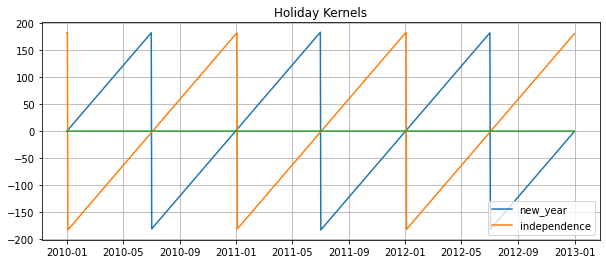

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ds = pd.date_range(start='2010-01-01', end='2012-12-31')
holiday_dist_new_year = holiday_kernel(holiday='new_year', dates=ds)
holiday_dist_independence = holiday_kernel(holiday='independence', dates=ds)

fig = plt.figure(figsize=(10,4))
plt.plot(ds, holiday_dist_new_year, label='new_year')
plt.plot(ds, holiday_dist_independence, label='independence')
plt.plot(ds, np.zeros(len(ds)))
plt.title('Holiday Kernels')
plt.grid()
plt.legend()
plt.show()

# Data Wrangling utility

In [ ]:
# export        
def check_nans(df):
    """
    Checks the missing values per each column in
    the `df` dataframe, for data wrangling logs.
        Parameters
        ----------
        df: Pandas dataframe
        Returns
        -------
        check_df: Pandas dataframe
    """
    n_rows = len(df)
    
    check_df = {'col': [], 'dtype': [], 'nan_prc': []}
    for col in df.columns:
        check_df['col'].append(col)
        check_df['dtype'].append(df[col].dtype)
        check_df['nan_prc'].append(df[col].isna().sum()/n_rows)
    
    check_df = pd.DataFrame(check_df)
    print("\n")
    print(f"dataframe n_rows {n_rows}")
    print(check_df)
    print("\n")
    
def one_hot_encoding(df, index_col):
    """
    Takes the `df` dataframe and encodes its
    categorical columns efficiently using sklearn's
    OneHotEncoder.
        Parameters
        ----------
        df: Pandas dataframe
        index_col: str
        Returns
        -------
        one_hot_concat_df: Pandas dataframe
    """    
    encoder = OneHotEncoder()
    columns = list(df.columns)
    columns.remove(index_col)
    one_hot_concat_df = pd.DataFrame(df[index_col].values, columns=[index_col])
    for col in columns:
        dummy_columns = [f'{col}_[{x}]' for x in list(df[col].unique())]
        dummy_values  = encoder.fit_transform(df[col].values.reshape(-1,1)).toarray()
        one_hot_df    = pd.DataFrame(dummy_values, columns=dummy_columns)        
        one_hot_concat_df = pd.concat([one_hot_concat_df, one_hot_df], axis=1)
        
    return one_hot_concat_df

def numpy_balance(*arrs):
    """
    Fast NumPy implementation of balance function.
    The function creates all the interactions between
    the NumPy arrays provided.
        Parameters
        ----------
        arrs: NumPy arrays
        Returns
        -------
        out: NumPy array
    """
    N = len(arrs)
    out =  np.transpose(np.meshgrid(*arrs, indexing='ij'),
                        np.roll(np.arange(N + 1), -1)).reshape(-1, N)
    return out

def numpy_ffill(arr):
    """
    Fast NumPy implementation of forwardfill function.
    The function fills missing/nan values with the 
    following value in the array.
        Parameters
        ----------
        arr: NumPy array    
        Returns
        -------
        arr: NumPy array
    """
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

def numpy_bfill(arr):
    """
    Fast NumPy implementation of backfill function.
    The function fills missing/nan values with the 
    previous value in the array.
        Parameters
        ----------
        arr: NumPy array    
        Returns
        -------
        arr: NumPy array
    """    
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), mask.shape[1] - 1)
    idx = np.minimum.accumulate(idx[:, ::-1], axis=1)[:, ::-1]
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out